In [1]:
import pandas

import swasputils

In [2]:
FILTERING_WORKFLOW = 17313

In [3]:
zoo_classifications = swasputils.ZooniverseClassifications().get_workflow(FILTERING_WORKFLOW)

C:\Users\anm83\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\anm83\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
zoo_classifications.decode_annotations()

In [5]:
value_counts = {}
for value in ('Real', 'Junk'):
    filtered_classifications = zoo_classifications.df[zoo_classifications.df['annotation_T0'] == value]['created_at']
    filtered_classifications = filtered_classifications.value_counts()
    filtered_classifications.index = pandas.to_datetime(filtered_classifications.index)
    filtered_classifications.name = value
    value_counts[value] = filtered_classifications.resample('1D').count()
value_counts = pandas.DataFrame(value_counts)

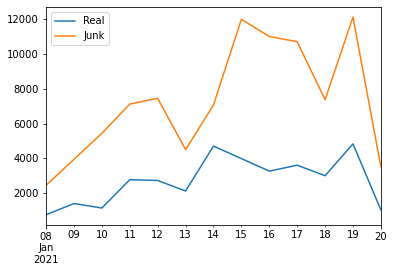

In [6]:
value_counts.plot()

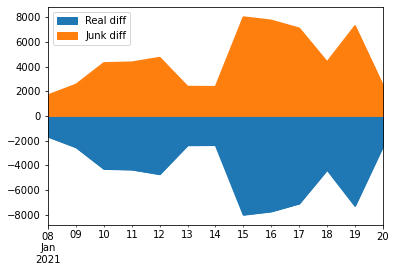

In [7]:
diff = value_counts['Real'] - value_counts['Junk']
value_counts['Real diff'] = diff
value_counts['Junk diff'] = -diff
value_counts[['Real diff', 'Junk diff']].plot.area()

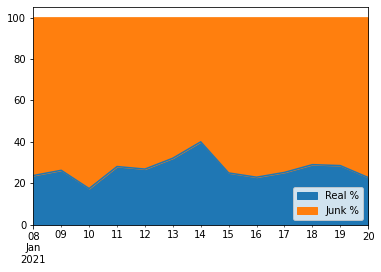

In [8]:
total = value_counts['Real'] + value_counts['Junk']
value_counts['Real %'] = value_counts['Real'] / total * 100
value_counts['Junk %'] = value_counts['Junk'] / total * 100
value_counts[['Real %', 'Junk %']].plot.area()